In [1]:
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatterSciNotation,LogLocator
%matplotlib inline

In [2]:
data = []
for metric_name in ['DiceAccuracy(threshold=0.5,smoothing=1)','DiceLoss(smoothing=1)']:
    table = []
    for csv_path in pathlib.Path(metric_name).rglob('*.csv'):
        metric_name,model_name,is_pretrained,purpose,csv_name = csv_path.as_posix().split('/')
        df = pd.read_csv(csv_path)
        df['ModelName'] = model_name
        df['IsPretrained'] = is_pretrained
        df['Purpose'] = purpose
        df['TrialNumber'] = csv_name.replace(f'_{purpose}','_').split('_')[-2]
        df = df.rename({'Step':'ImagesCount'},axis='columns')
        df = df.rename({'Value':metric_name},axis='columns')
        df = df.drop('Wall time',axis='columns')
        table.append(df)
    data.append(pd.concat(table).set_index(['ImagesCount','ModelName','IsPretrained','Purpose','TrialNumber']))
data = pd.concat(data,axis='columns')
data = data.reset_index()
data = data.replace({'Purpose':{'validation_wo_arg':'validation_w/o_arg'}})

images_count_to_epoch = {i:e+1 for e,i in enumerate(sorted(data['ImagesCount'].value_counts(ascending=False)[:30].index))}
epoch_data = data.loc[data['ImagesCount'].isin(images_count_to_epoch.keys())]
epoch_data.insert(1,'Epoch',epoch_data['ImagesCount'].replace(images_count_to_epoch))

epoch_train = epoch_data.query("Purpose=='train'").set_index(['Epoch','ModelName','IsPretrained','TrialNumber']).iloc[:,2:]
epoch_validation = epoch_data.query("Purpose=='validation'").set_index(['Epoch','ModelName','IsPretrained','TrialNumber']).iloc[:,2:]
epoch_validation_wo_arg = epoch_data.query("Purpose=='validation_wo_arg'").set_index(['Epoch','ModelName','IsPretrained','TrialNumber']).iloc[:,2:]

epoch_validation_vs_train = (epoch_validation - epoch_train).reset_index()
epoch_validation_wo_arg_vs_train = (epoch_validation_wo_arg - epoch_train).reset_index()
epoch_validation_wo_arg_vs_validation = (epoch_validation_wo_arg - epoch_validation).reset_index()

In [ ]:
pd.options.display.max_rows = 1000
data.groupby(['ModelName','IsPretrained','Purpose','TrialNumber'])['ImagesCount'].count()

In [4]:
def draw_box_plot(
    data,
    scope,
    metric,
    hue,
    title,
    drop=[],
    figsize=(20,10),
    logy=False,
    font_scale=2,
    whis=[20,80]):
    
    sns.set_theme(style="ticks", palette="pastel",font_scale = font_scale)
    scope = list(scope)
    data = data.copy().loc[data.iloc[:,0].isin(scope)]
    if isinstance(hue,str):
        hue = [hue]
    else:
        assert isinstance(hue,list)

    if hue != ['']:
        data['Model'] = data[hue].apply(lambda x: '_'.join(x),axis=1)
        
        if isinstance(drop,str):
            drop = [drop]
        else:
            assert isinstance(drop,list)

        data = data.loc[~data['Model'].isin(drop)]
        
        hue_order = sorted(data['Model'].unique())
        
        f, ax = plt.subplots(figsize=figsize)
        sns.stripplot(
            x=data.columns[0],
            y=metric,
            hue='Model',
            hue_order = hue_order,
            data=data,
            dodge=True,
            edgecolor='black',
            linewidth=0.5)
        
        box_ax = sns.boxplot(
            x=data.columns[0],
            y=metric,
            hue='Model',
            hue_order = hue_order,
            data=data,
            showfliers=False,
            whis=whis,
            showmeans=True,
            meanline=True,
            meanprops={'color': 'k'},
            )
        
        handles, labels = box_ax.get_legend_handles_labels()
        plt.legend(handles[:len(handles)//2], labels[:len(labels)//2], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    else:
        f, ax = plt.subplots(figsize=figsize)
        sns.stripplot(
            x=data.columns[0],
            y=metric,
            data=data,
            color='b',
            edgecolor='black',
            linewidth=0.5)
        
        box_ax = sns.boxplot(
            x=data.columns[0],
            y=metric,
            data=data,
            color='b',
            showfliers=False,
            whis=whis,
            showmeans=True,
            meanline=True,
            meanprops={'color': 'k'},
            )

    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    if logy:
        ax.set_yscale("log")
        ax.yaxis.set_minor_locator(LogLocator(subs=(2,4,6,8)))
        ax.yaxis.set_minor_formatter(LogFormatterSciNotation(labelOnlyBase=False,minor_thresholds=(np.inf, np.inf)))
        ax.yaxis.grid(True,which='minor')
    plt.title(title)
    f.tight_layout()
    plt.show()

In [5]:
def draw_pointplot(x,y,data,hue):
    ylim=(0.035,0.3)
    logy=True
    
    ax = sns.pointplot(
        x=x,
        y=y,
        data=data,
        dodge=True,
        hue=hue)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    if ylim != None:
        ax.set_ylim(ylim)
    if logy:
        ax.set_yscale("log")
        ax.yaxis.set_minor_locator(LogLocator(subs=(2,4,6,8)))
        ax.yaxis.set_minor_formatter(LogFormatterSciNotation(labelOnlyBase=False,minor_thresholds=(np.inf, np.inf)))
        ax.yaxis.grid(True,which='minor')
    plt.legend(title='')

In [6]:
def draw_lineplot(x,y,data,hue,units):
    ylim=(0.04,1)
    logy=False
    ax = sns.lineplot(
        x=x,
        y=y,
        data=data,
        hue=hue,
        units=units,
        estimator=None)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    if ylim != None:
        ax.set_ylim(ylim)
    if logy:
        ax.set_yscale("log")
        ax.yaxis.set_minor_locator(LogLocator(subs=(2,4,6,8)))
        ax.yaxis.set_minor_formatter(LogFormatterSciNotation(labelOnlyBase=False,minor_thresholds=(np.inf, np.inf)))
        ax.yaxis.grid(True,which='minor')
    plt.legend(title='')

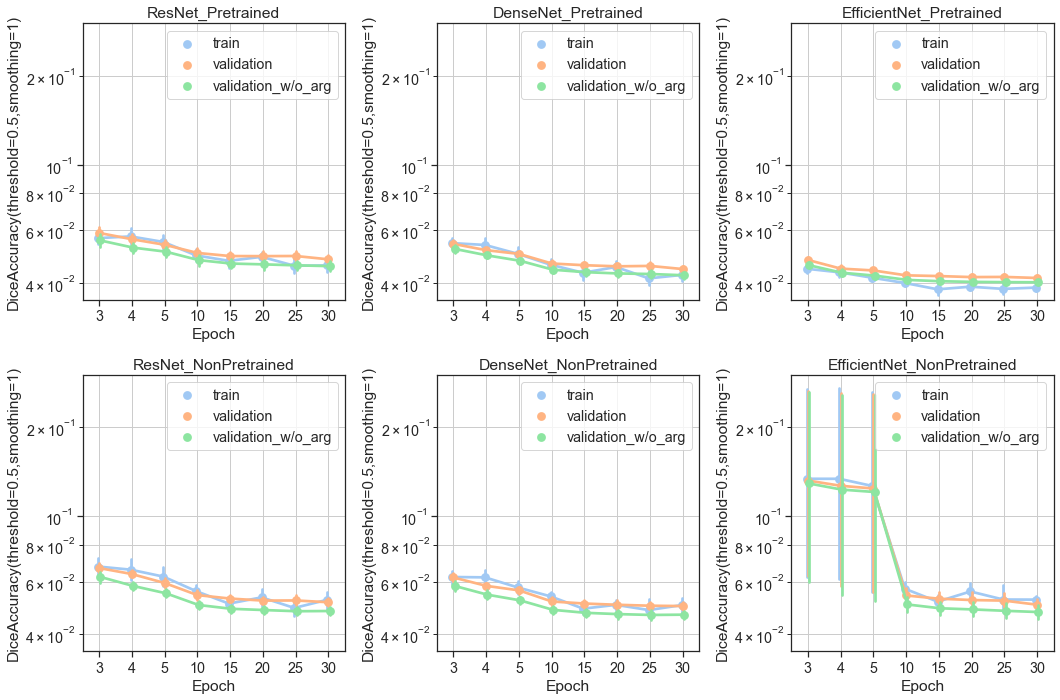

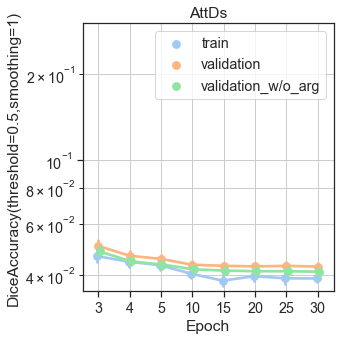

In [7]:
sns.set_theme(style="ticks", palette="pastel",font_scale = 1.3)
f, ax = plt.subplots(2,3,figsize=(15,10))

for a in ax.flatten():
    a.set_axis_off()

for i,modelname in enumerate(['ResNet','DenseNet','EfficientNet']):
    f.add_subplot(2,3,i+1)
    plt.title(modelname+'_Pretrained')
    draw_pointplot(
        x='Epoch',
        y='DiceAccuracy(threshold=0.5,smoothing=1)',
        data=epoch_data.loc[epoch_data['Epoch'].isin([3,4]+list(range(5,31,5)))].query(f"ModelName=='{modelname}'&IsPretrained=='Pretrained'"),
        hue='Purpose')

    f.add_subplot(2,3,i+4)
    plt.title(modelname+'_NonPretrained')
    draw_pointplot(
        x='Epoch',
        y='DiceAccuracy(threshold=0.5,smoothing=1)',
        data=epoch_data.loc[epoch_data['Epoch'].isin([3,4]+list(range(5,31,5)))].query(f"ModelName=='{modelname}'&IsPretrained=='NonPretrained'"),
        hue='Purpose')
plt.tight_layout()
plt.show()

sns.set_theme(style="ticks", palette="pastel",font_scale = 1.3)
plt.subplots(figsize=(5,5))
plt.title('AttDs')
draw_pointplot(
    x='Epoch',
    y='DiceAccuracy(threshold=0.5,smoothing=1)',
    data=epoch_data.loc[epoch_data['Epoch'].isin([3,4]+list(range(5,31,5)))].query(f"ModelName=='AttDs'"),
    hue='Purpose')
plt.tight_layout()
plt.show()

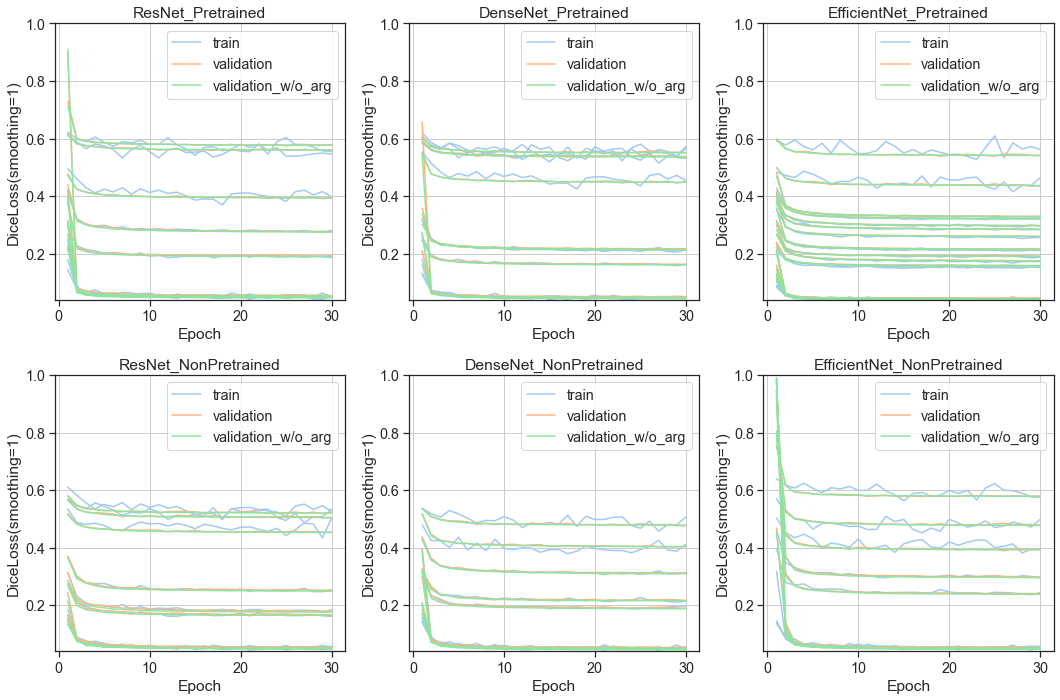

In [8]:
sns.set_theme(style="ticks", palette="pastel",font_scale = 1.3)
f, ax = plt.subplots(2,3,figsize=(15,10))

for a in ax.flatten():
    a.set_axis_off()

for i,modelname in enumerate(['ResNet','DenseNet','EfficientNet']):
    f.add_subplot(2,3,i+1)
    plt.title(modelname+'_Pretrained')
    draw_lineplot(
        x='Epoch',
        y='DiceLoss(smoothing=1)',
        data=epoch_data.query(f"ModelName=='{modelname}'&IsPretrained=='Pretrained'"),
        hue='Purpose',
        units='TrialNumber')

    f.add_subplot(2,3,i+4)
    plt.title(modelname+'_NonPretrained')
    draw_lineplot(
        x='Epoch',
        y='DiceLoss(smoothing=1)',
        data=epoch_data.query(f"ModelName=='{modelname}'&IsPretrained=='NonPretrained'"),
        hue='Purpose',
        units='TrialNumber')
    
plt.tight_layout()
plt.show()

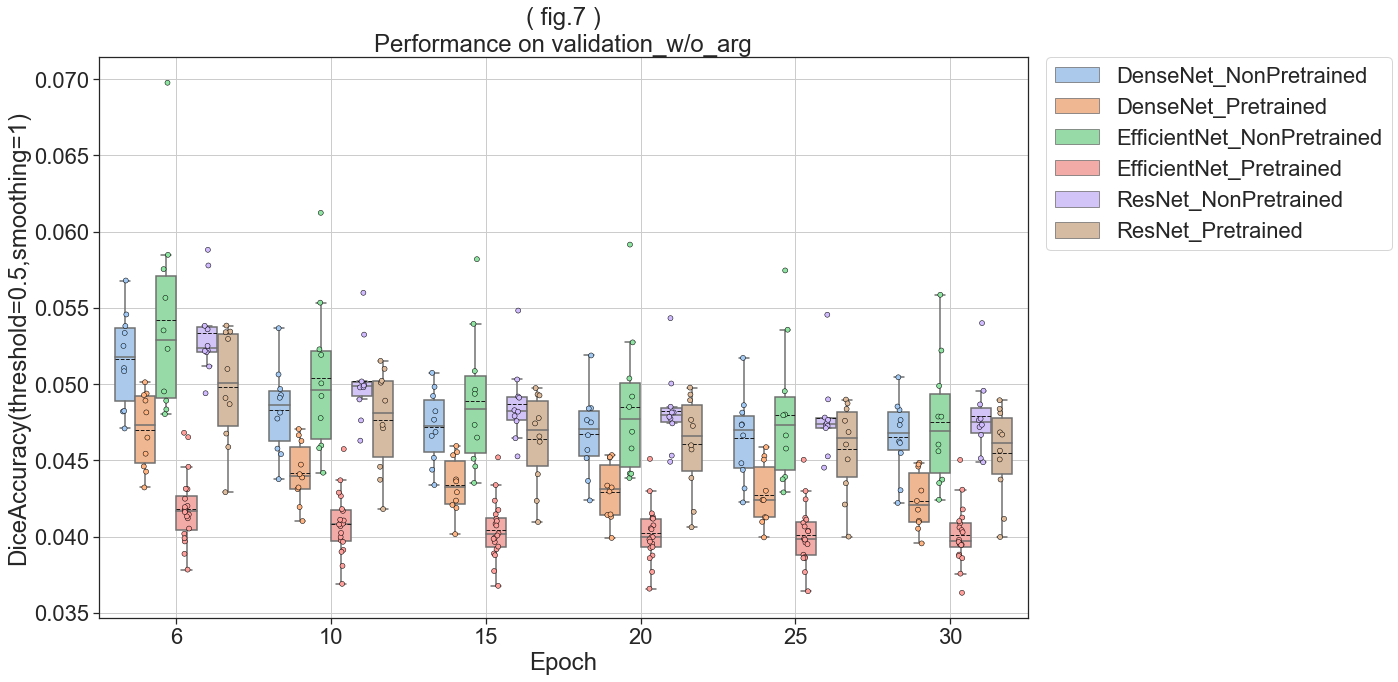

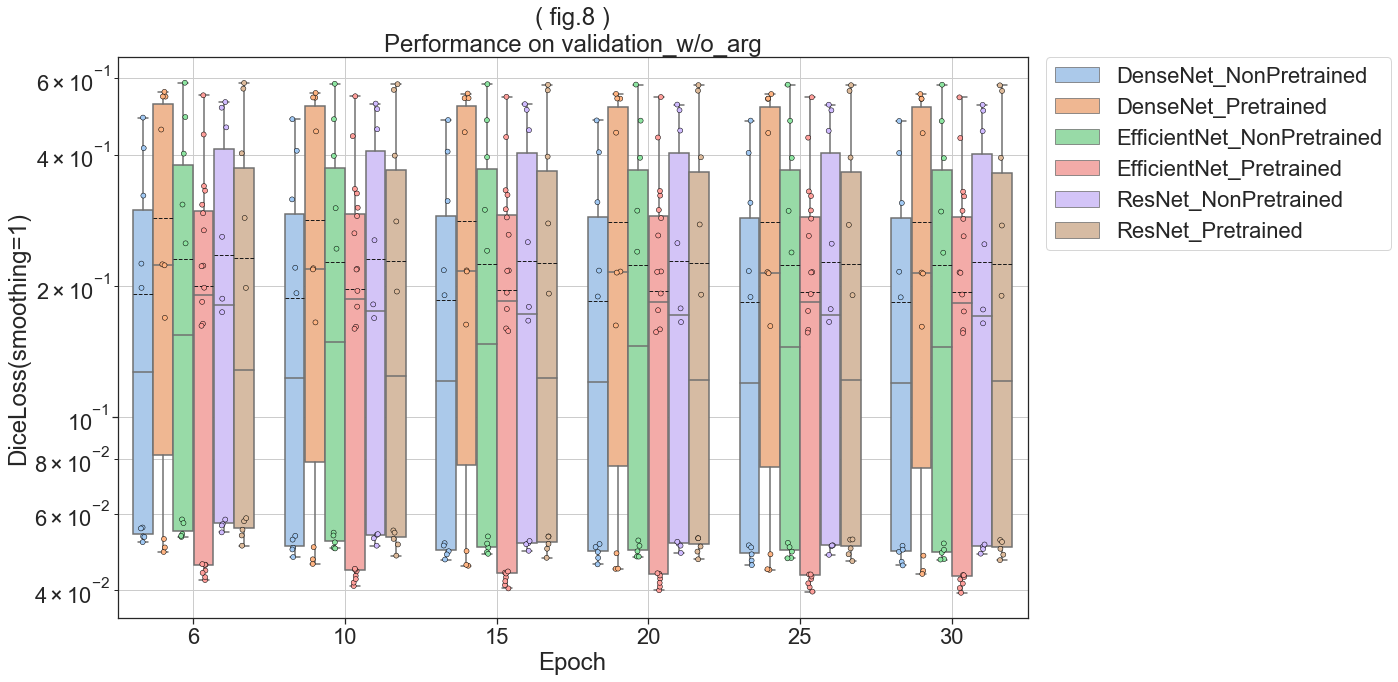

In [9]:
draw_box_plot(
    epoch_data.iloc[:,1:].query("Purpose=='validation_w/o_arg'"),
    [6]+list(range(10,31,5)),
    'DiceAccuracy(threshold=0.5,smoothing=1)',
    ['ModelName','IsPretrained'],
    '( fig.7 )\nPerformance on validation_w/o_arg',
    drop=['AttDs_Pretrained'],
    whis=1.5)

draw_box_plot(
    epoch_data.iloc[:,1:].query("Purpose=='validation_w/o_arg'"),
    [6]+list(range(10,31,5)),
    'DiceLoss(smoothing=1)',
    ['ModelName','IsPretrained'],
    '( fig.8 )\nPerformance on validation_w/o_arg',
    drop=['AttDs_Pretrained'],
    logy=True,
    whis=1.5)

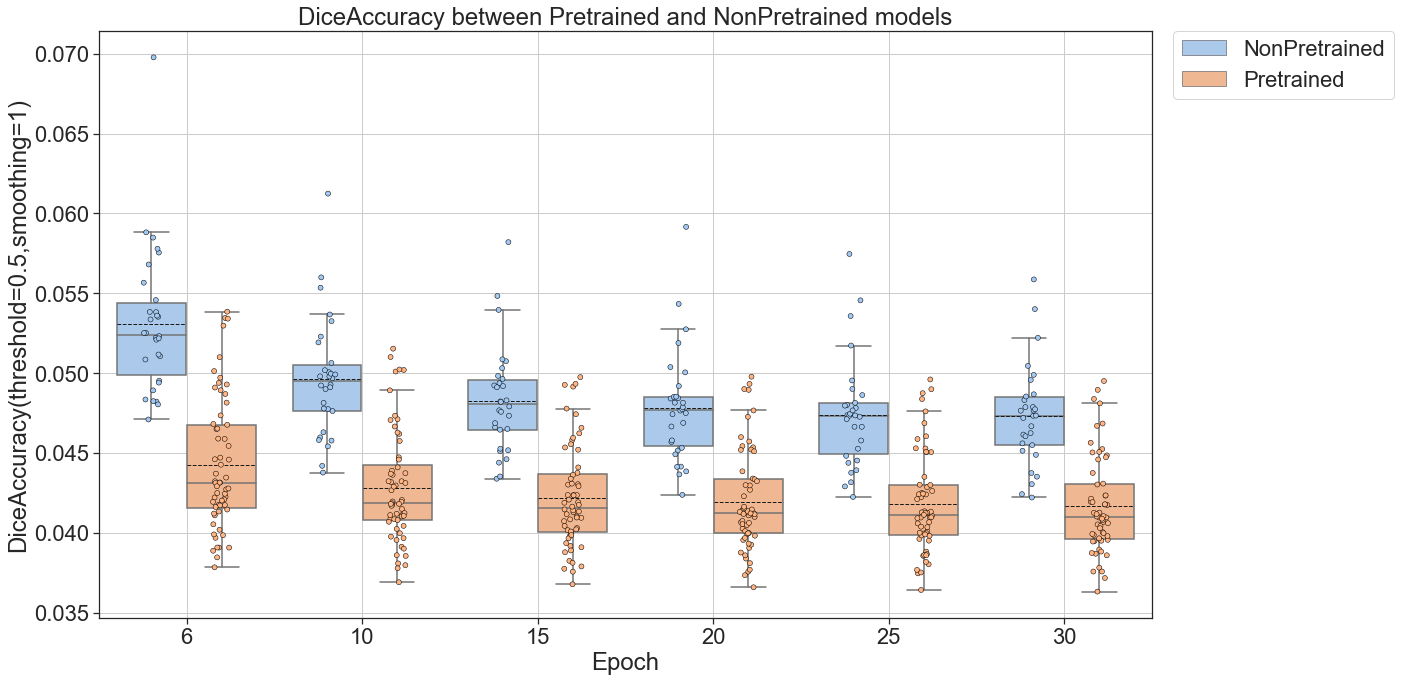

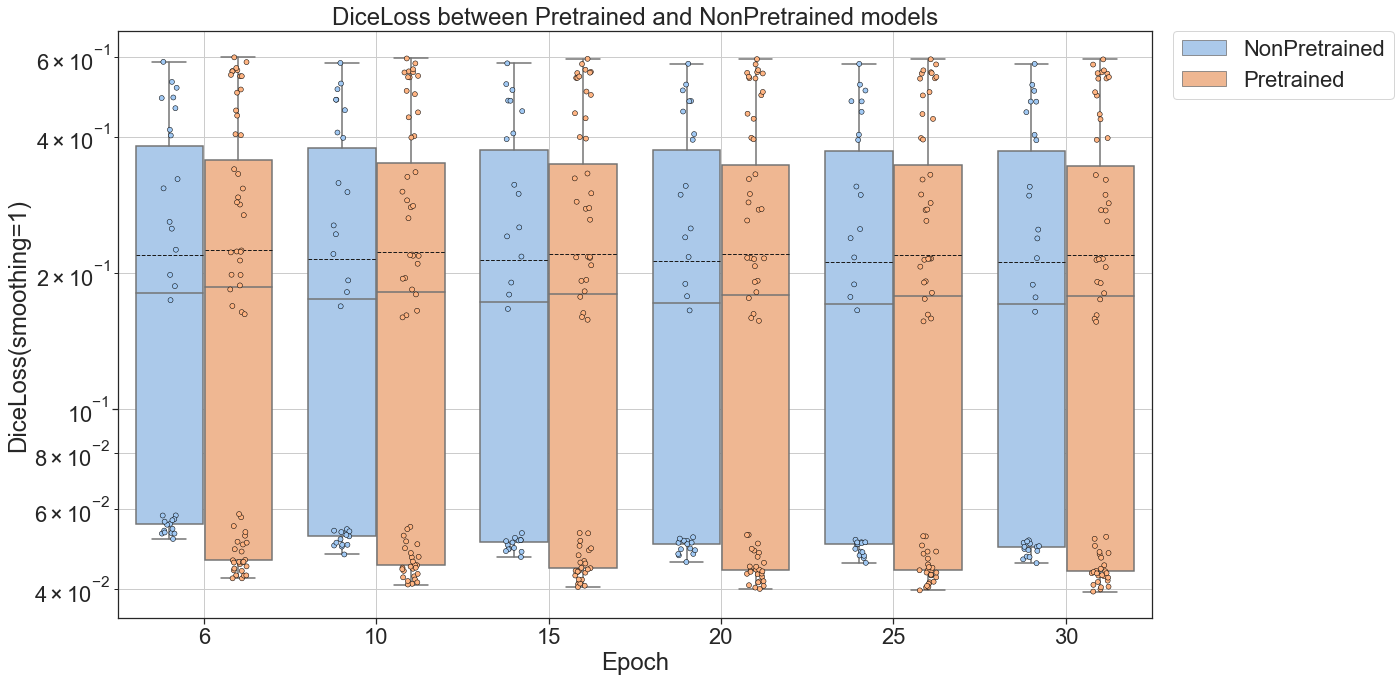

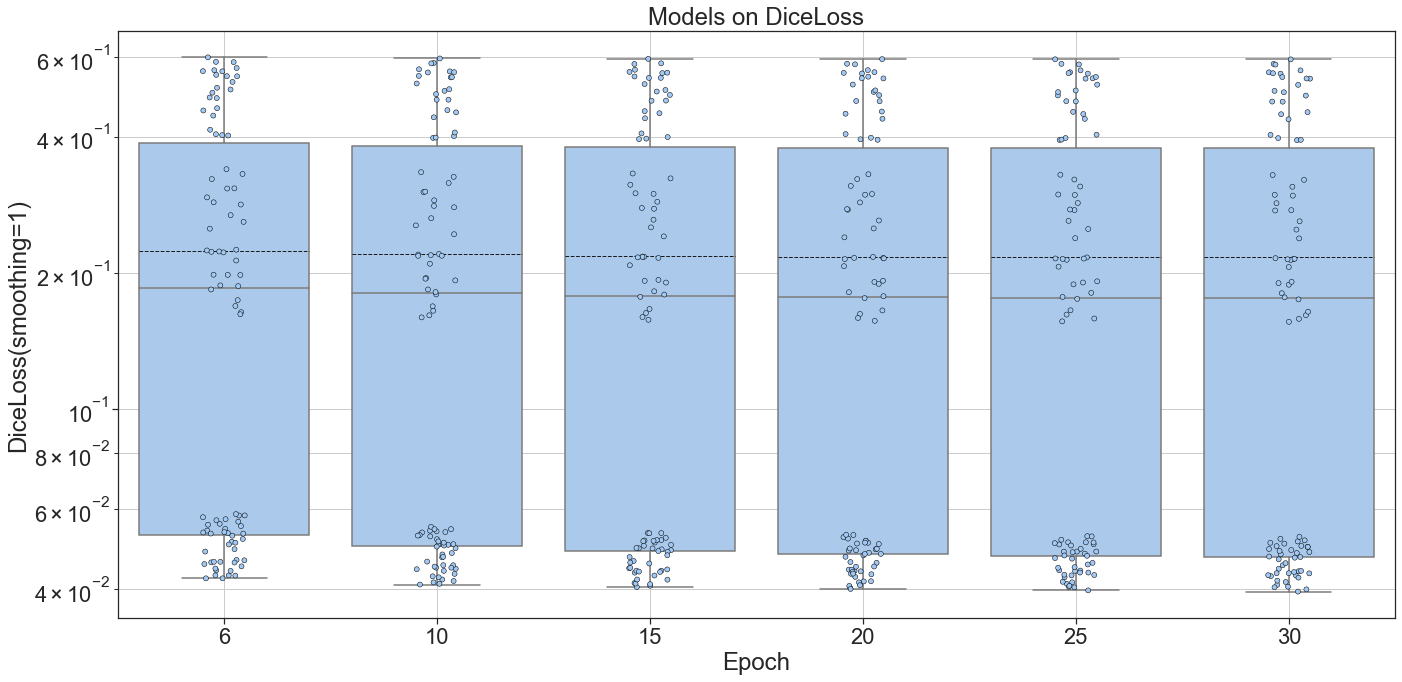

In [10]:
draw_box_plot(
    epoch_data.iloc[:,1:].query("Purpose=='validation_w/o_arg'"),
    [6]+list(range(10,31,5)),
    'DiceAccuracy(threshold=0.5,smoothing=1)',
    ['IsPretrained'],
    'DiceAccuracy between Pretrained and NonPretrained models',
    drop=['AttDs_Pretrained'],
    whis=1.5)

draw_box_plot(
    epoch_data.iloc[:,1:].query("Purpose=='validation_w/o_arg'"),
    [6]+list(range(10,31,5)),
    'DiceLoss(smoothing=1)',
    ['IsPretrained'],
    'DiceLoss between Pretrained and NonPretrained models',
    drop=['AttDs_Pretrained'],
    logy=True,
    whis=1.5)

draw_box_plot(
    epoch_data.iloc[:,1:].query("Purpose=='validation_w/o_arg'"),
    [6]+list(range(10,31,5)),
    'DiceLoss(smoothing=1)',
    [''],
    'Models on DiceLoss',
    drop=['AttDs_Pretrained'],
    logy=True,
    whis=1.5)

In [11]:
metrics_difference_epoch_data = epoch_data.copy()
metrics_difference_epoch_data['diff'] = epoch_data['DiceLoss(smoothing=1)']-epoch_data['DiceAccuracy(threshold=0.5,smoothing=1)']

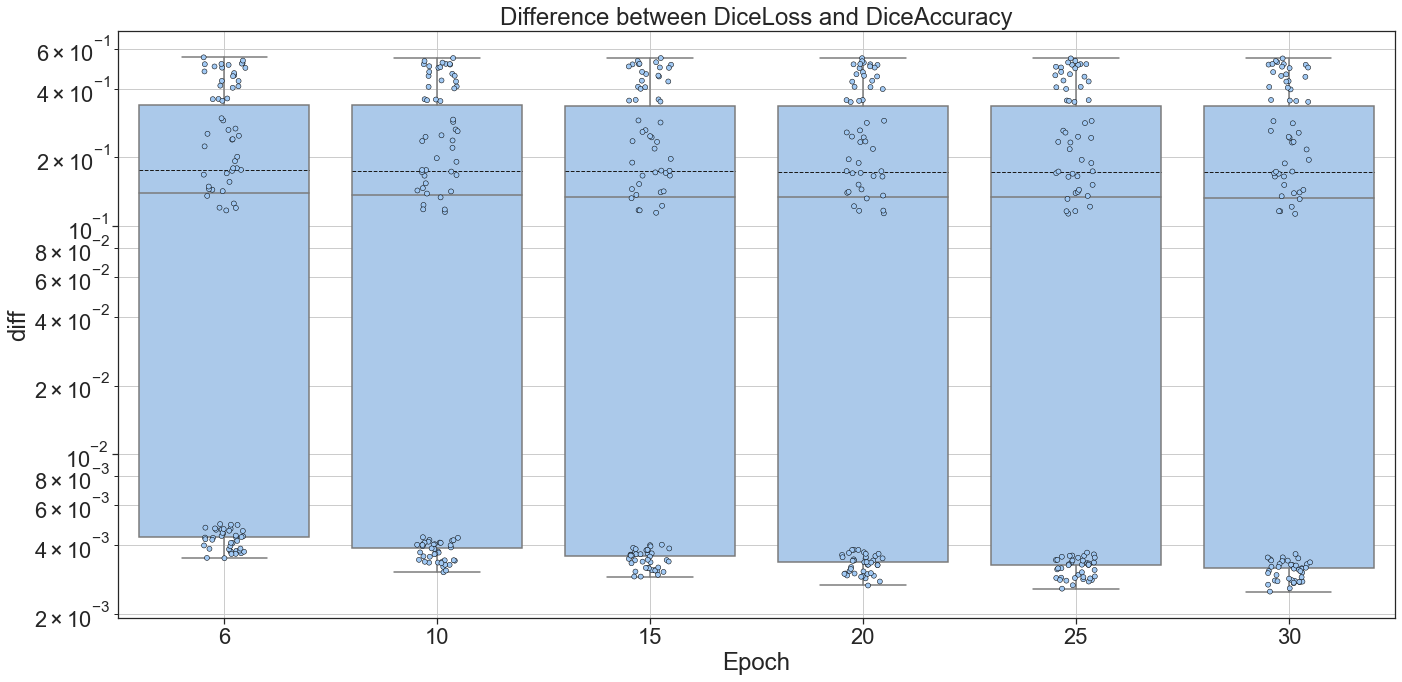

In [12]:
draw_box_plot(
    metrics_difference_epoch_data.iloc[:,1:].query("Purpose=='validation_w/o_arg'"),
    [6]+list(range(10,31,5)),
    'diff',
    [''],
    'Difference between DiceLoss and DiceAccuracy',
    drop=['AttDs_Pretrained'],
    logy=True,
    whis=1.5)

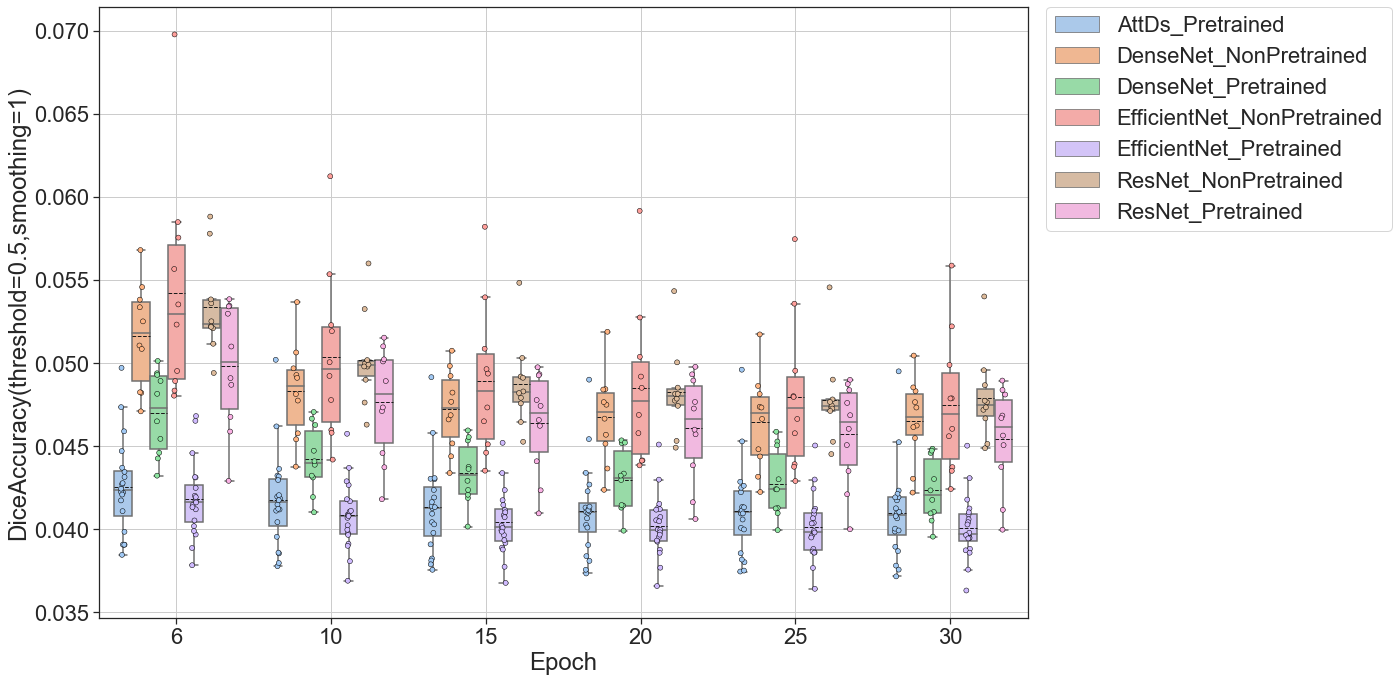

In [13]:
draw_box_plot(
    epoch_data.iloc[:,1:].query("Purpose=='validation_w/o_arg'"),
    [6]+list(range(10,31,5)),
    'DiceAccuracy(threshold=0.5,smoothing=1)',
    ['ModelName','IsPretrained'],
    '',
    whis=1.5)

In [14]:
keep = metrics_difference_epoch_data.query('Epoch==30&Purpose=="validation_w/o_arg"&diff<0.01').set_index(['ModelName','IsPretrained','TrialNumber']).index
keep = epoch_data.set_index(['ModelName','IsPretrained','TrialNumber']).loc[keep].reset_index()
keep = keep.reindex(epoch_data.columns,axis='columns')

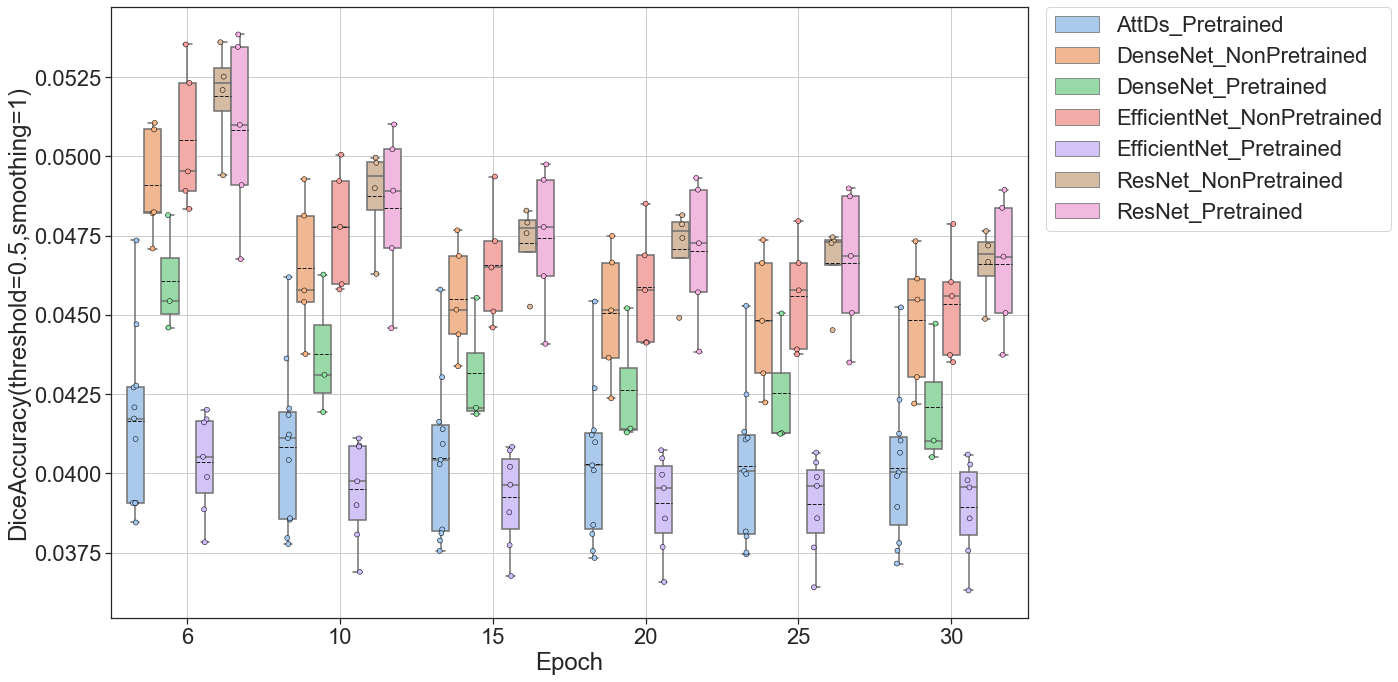

In [15]:
draw_box_plot(
    keep.iloc[:,1:].query("Purpose=='validation_w/o_arg'"),
    [6]+list(range(10,31,5)),
    'DiceAccuracy(threshold=0.5,smoothing=1)',
    ['ModelName','IsPretrained'],
    '',
    whis=1.5)